In [83]:
from pathlib import Path
from typing import Union
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
sns.set_theme('paper')

In [62]:
MERGED_LOAD_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "merged.parquet"
)
X_TEST_SAVE_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "X_test.parquet"
)
y_TEST_SAVE_DIR = Path(
    Path.cwd().parent, "data.nosync", "transformed_data", "y_test.parquet"
)

In [63]:
df = pd.read_parquet(MERGED_LOAD_DIR)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509980 entries, 0 to 15509979
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Time Stamp    datetime64[ns]
 1   Name          object        
 2   PTID          float32       
 3   Load          float32       
 4   Year          int32         
 5   Month         int32         
 6   Day           int32         
 7   Minute        int32         
 8   Hour          int32         
 9   Max Temp      float64       
 10  Min Temp      float64       
 11  Max Wet Bulb  float64       
 12  Min Wet Bulb  float64       
dtypes: datetime64[ns](1), float32(2), float64(4), int32(5), object(1)
memory usage: 1.1+ GB


Looks like all the datatypes are reasonable.

In [65]:
df.nunique()

Time Stamp      1550821
Name                 10
PTID                 10
Load            2997727
Year                 16
Month                12
Day                  31
Minute               60
Hour                 24
Max Temp           3307
Min Temp           3365
Max Wet Bulb       2987
Min Wet Bulb       3257
dtype: int64

In [66]:
name_ptid_mapping_df = df.groupby('Name').apply(lambda x: x['PTID'].unique())
name_ptid_mapping = dict(zip(name_ptid_mapping_df.index, [x[0] for x in name_ptid_mapping_df.values]))
name_ptid_mapping

{'CAPITL': 61757.0,
 'CENTRL': 61754.0,
 'DUNWOD': 61760.0,
 'GENESE': 61753.0,
 'HUD VL': 61758.0,
 'LONGIL': 61762.0,
 'MHK VL': 61756.0,
 'N.Y.C.': 61761.0,
 'NORTH': 61755.0,
 'WEST': 61752.0}

Each 'Name' has a unique PTID assosciated with it, therefore we can drop one of these as they are perfectly correlated. Probably drop the name column as we would have to one hot encode this anyway and just use the PTID

In [67]:
df.isna().sum()

Time Stamp           0
Name                 0
PTID                 0
Load               357
Year                 0
Month                0
Day                  0
Minute               0
Hour                 0
Max Temp             0
Min Temp             0
Max Wet Bulb         0
Min Wet Bulb    809810
dtype: int64

The missing load values will have to be dropped, but we should be able to impute the missing min wet bulb temp from the other columns. 

In [68]:
df.head()

,Time Stamp,Name,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
0,2016-06-22 00:00:00,CAPITL,61757.0,1252.099976,2016,6,22,0,0,27.777778,15.0,18.444444,11.777778
1,2016-06-22 00:05:00,CAPITL,61757.0,1239.199951,2016,6,22,5,0,27.777778,15.0,18.444444,11.777778
2,2016-06-22 00:10:00,CAPITL,61757.0,1241.900024,2016,6,22,10,0,27.777778,15.0,18.444444,11.777778
3,2016-06-22 00:15:00,CAPITL,61757.0,1240.900024,2016,6,22,15,0,27.777778,15.0,18.444444,11.777778
4,2016-06-22 00:20:00,CAPITL,61757.0,1226.900024,2016,6,22,20,0,27.777778,15.0,18.444444,11.777778


# Rounding

We dont need 6 significant figures for load and temperatures as the sensors are unlikely to be this accurate anyway, we can round these to help speed up our modelling. 

In [69]:
df['Load'] = df['Load'].round(2)
df['Max Temp'] = df['Max Temp'].round(2)
df['Min Temp'] = df['Min Temp'].round(2)
df['Max Wet Bulb'] = df['Max Wet Bulb'].round(2)
df['Min Wet Bulb'] = df['Min Wet Bulb'].round(2)

# Cyclical transformations

Time features are cyclical in nature, however ML algorithms don't know this and assume that December (12) is very different to January (1). To remedy this we can apply sine/cosine transformations to the data to move the extremities closer together. 

This can happen before splitting into train/test as no other information from the dataset is required, so no data leakage. 

<Axes: >

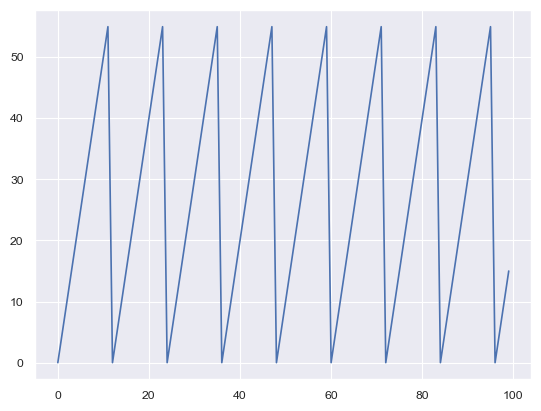

In [70]:
# Demonstrating the distribution of minutes prior to transformation
df[df['Name'] == 'CAPITL'].iloc[0:100]['Minute'].plot()

To Further demonstrate the problem we can look at a subsample of the data

In [71]:
df[df['Name'] == 'CAPITL'].iloc[10:14]

,Time Stamp,Name,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb
10,2016-06-22 00:50:00,CAPITL,61757.0,1211.800049,2016,6,22,50,0,27.78,15.0,18.44,11.78
11,2016-06-22 00:55:00,CAPITL,61757.0,1193.400024,2016,6,22,55,0,27.78,15.0,18.44,11.78
12,2016-06-22 01:00:00,CAPITL,61757.0,1179.199951,2016,6,22,0,1,27.78,15.0,18.44,11.78
13,2016-06-22 01:05:00,CAPITL,61757.0,1180.099976,2016,6,22,5,1,27.78,15.0,18.44,11.78


Looking at the 'Minute' column we can see that in, in reality, there are only 5 minute between 55 - 0, however an ML algorithm would assume this as 55 - 0 = 55 minutes difference. 

A common method for encoding cyclical data is to transform the data into two dimensions using a sine and consine transformation.

We can do that using the following transformations:


$$x_{sin} = sin(\frac{2*\pi*x}{max(x)}) $$
$$x_{cos} = cos(\frac{2*\pi*x}{max(x)}) $$

In [72]:
def encode_sin_cos(data:pd.DataFrame, col:str, max_val:Union[int, float]) -> pd.DataFrame:
    """Create two new columns within a given dataframe to encode specified cols with sin and cos transformations

    Args:
        data (pd.DataFrame): Dataframe containing cols to encode
        col (str): column to encode (month, yeah, minute etc)
        max_val (Union[int, float]): maximum value of the given column

    Returns:
        pd.DataFrame: original dataframe with additional columns
    """
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [73]:
df = encode_sin_cos(df, 'Month', df['Month'].max())
df = encode_sin_cos(df, 'Day', df['Day'].max())
df = encode_sin_cos(df, 'Minute', df['Minute'].max())
df = encode_sin_cos(df, 'Hour', df['Hour'].max())

Lets see what the newly transformed columns look like. 

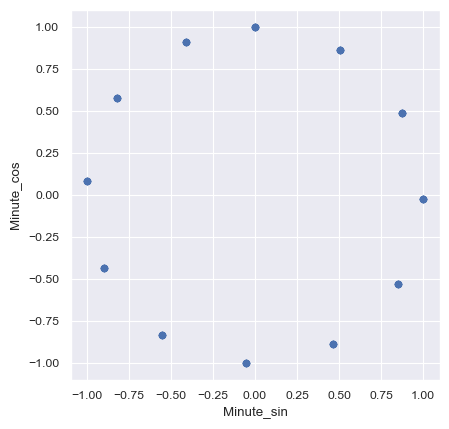

In [74]:
ax = df[df['Name'] == 'CAPITL'].iloc[0:100].plot.scatter('Minute_sin', 'Minute_cos').set_aspect('equal')

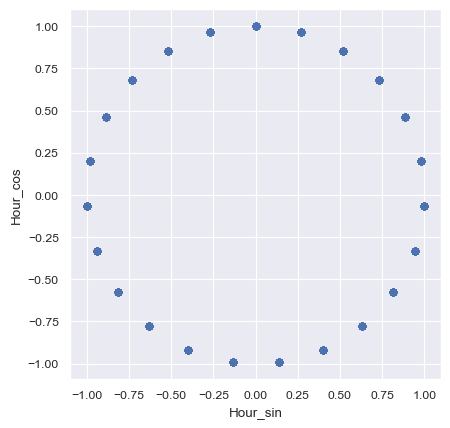

In [75]:
ax = df[df['Name'] == 'CAPITL'].plot.scatter('Hour_sin', 'Hour_cos').set_aspect('equal')

Exactly what we wanted, the data is now encoded as a cycle.

# Dropping unused rows and columns

In [76]:
df = df[~df['Load'].isna()]
df = df.drop(['Name'], axis = 1, errors = 'ignore').reset_index(drop = True) #Each name has a unique PTID

# Test Train Split

The transformations we've done so far havent looked at any of the data other than individual rows, however for firther transformations (normalizing, handling missing values) we should first perform the test/train split to avoid any data leakage into our test set. 

Time series data means we need to be careful how we split the data. 

In [77]:
tss = TimeSeriesSplit(n_splits = 2)
df = df.set_index('Time Stamp')
df = df.sort_index()
X = df.drop(['Load'], axis = 1)
y = df['Load']

In [78]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

We can check the test train split has worked correctly by plotting. 

<Axes: xlabel='Time Stamp'>

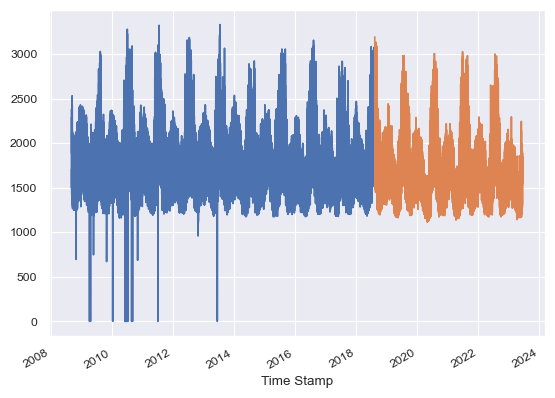

In [79]:
y_train.groupby('Time Stamp').mean().plot()
y_test.groupby('Time Stamp').mean().plot()

Orange is the test set (newer) and blue is the train set (older)

In [80]:
X_test.to_parquet(X_TEST_SAVE_DIR)
pd.DataFrame(y_test).to_parquet(y_TEST_SAVE_DIR)

# Preprocessing

Plan: 
1. Impute missing Min wet bulb temp
2. Normalize values
3. Convert time stamp info to ordinal 

In [81]:
df = df.reset_index()

## Imputing

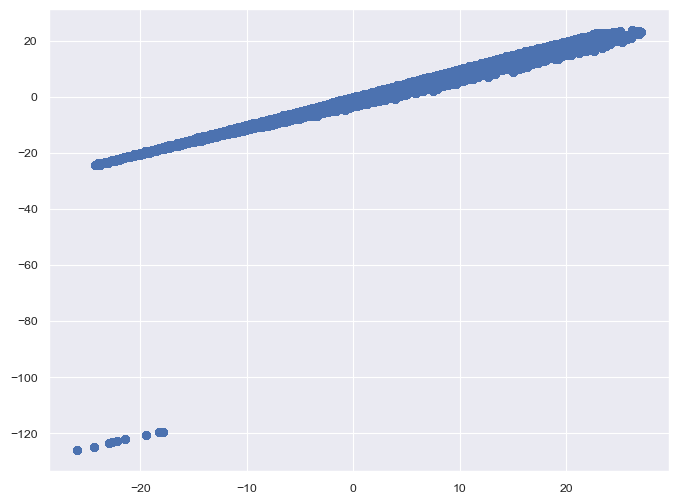

In [91]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(x = df['Min Temp'], y = df['Min Wet Bulb'])

In [87]:
imp = IterativeImputer(max_iter=10, random_state=0)
imputed = imp.fit_transform(df.drop('Time Stamp', axis = 1))
# df_imputed = pd.DataFrame(imputed, columns=df.columns)

KeyboardInterrupt: 

In [82]:
df.head()

,Time Stamp,PTID,Load,Year,Month,Day,Minute,Hour,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,Month_sin,Month_cos,Day_sin,Day_cos,Minute_sin,Minute_cos,Hour_sin,Hour_cos
0,2008-09-08,61758.0,974.400024,2008,9,8,0,0,26.67,16.89,20.78,15.83,-1.0,-1.836970e-16,0.998717,-0.050649,0.0,1.0,0.0,1.0
1,2008-09-08,61756.0,775.900024,2008,9,8,0,0,23.19,14.56,18.22,13.31,-1.0,-1.836970e-16,0.998717,-0.050649,0.0,1.0,0.0,1.0
2,2008-09-08,61762.0,2446.399902,2008,9,8,0,0,26.56,19.89,21.44,18.00,-1.0,-1.836970e-16,0.998717,-0.050649,0.0,1.0,0.0,1.0
3,2008-09-08,61752.0,1516.900024,2008,9,8,0,0,21.78,14.89,17.67,13.22,-1.0,-1.836970e-16,0.998717,-0.050649,0.0,1.0,0.0,1.0
4,2008-09-08,61755.0,703.000000,2008,9,8,0,0,22.89,14.11,18.22,13.22,-1.0,-1.836970e-16,0.998717,-0.050649,0.0,1.0,0.0,1.0
